> If running this for the first time: Run this cell. When the cell is complete, select the refresh icon on the Jupyter Notebooks toolbar to restart the kernel (The circle to the left of the kernel name: "Python 3 (ipykernel)" will be clear when the cell is finished running)

In [ ]:
%%capture
!pip install numpy pandas matplotlib seaborn scikit-learn ipywidgets

# Introduction
## Overview
This Jupyter Notebook presents an interactive machine learning model designed to predict outcomes of fights based on various fighter statistics. The model is trained on data from past fights, encompassing features like reach, height, strike accuracy, and age.
## Objective
The primary objective of this model is to provide insights into potential fight outcomes and to identify which matchups are likely to be the most competitive and interesting based on the model's confidence in its predictions.

In [1]:
import pandas as pd

df = pd.read_csv('moderate_divisions_dataset.csv')

> Ignore the pandas warning

In [2]:
unique_divisions = df['division'].unique()
print(unique_divisions)

['Heavyweight' 'Lightweight' 'Middleweight' 'Welterweight'
 'Light Heavyweight' 'Featherweight' 'Bantamweight' 'Flyweight']


In [3]:
division_dataframes = {}
for division in unique_divisions:
    division_dataframes[division] = df[df['division'] == division]

In [4]:
for division in unique_divisions:
    num_rows, num_columns = division_dataframes[division].shape
    print(f"{division} has {num_rows} data points")

Heavyweight has 1025 data points
Lightweight has 2138 data points
Middleweight has 1600 data points
Welterweight has 2110 data points
Light Heavyweight has 1144 data points
Featherweight has 1201 data points
Bantamweight has 1053 data points
Flyweight has 507 data points


In [5]:
columns_to_drop = ['date', 'fighter', 'opponent', 'division', 'stance', 'dob', 'method', 'total_comp_time', 'round', 'time']
for division in unique_divisions:
    dfc = division_dataframes[division].copy()
    dfc['date'] = pd.to_datetime(dfc['date'])
    dfc['dob'] = pd.to_datetime(dfc['dob'])
    
    dfc['age'] = dfc['date'].dt.year - dfc['dob'].dt.year
    
    dfc = dfc.drop(columns=columns_to_drop)
    
    division_dataframes[division] = dfc

In [6]:
print(division_dataframes['Heavyweight'].tail())

      result  reach  height  total_strikes_accuracy  age
1020       1   79.0    75.0               62.068966   31
1021       0   78.0    74.0               33.333333   34
1022       1   80.0    79.0               56.756757   34
1023       0   79.0    75.0               68.292683   34
1024       1   79.0    76.0               65.384615   33


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
columns_to_scale = ['reach', 'height', 'total_strikes_accuracy', 'age']

for division in unique_divisions:
    division_dataframes[division][columns_to_scale] = scaler.fit_transform(division_dataframes[division][columns_to_scale])

In [8]:
print(division_dataframes['Lightweight'].tail())

      result     reach    height  total_strikes_accuracy       age
3158       1  1.145438  0.211730               -0.533304  0.423222
3159       0 -0.207571  0.211730                1.711150  0.685498
3160       1 -0.658574 -0.317719                1.511926 -0.625878
3161       0  0.243432 -1.376619               -0.560002 -0.888154
3162       1 -0.658574  0.211730                0.782239  0.685498


# The Model
## Description
The model is a Support Vector Classifier (SVC), a powerful machine learning algorithm suitable for binary classification tasks. The SVC model tries to find the optimal boundary that best separates the dataset into two classes.

## Features
The following features are considered in the model:
- Reach: The reach of the fighter.
- Height: The height of the fighter.
- Strike Accuracy: The accuracy of the fighter's strikes.
- Age: The age of the fighter.

In [9]:
from sklearn.model_selection import train_test_split

division_train_test_splits = {}

for division, df in division_dataframes.items():
    
    X = df[['reach', 'height', 'total_strikes_accuracy', 'age']]
    y = df['result']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    division_train_test_splits[division] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }

In [10]:
from sklearn.svm import SVC

trained_models = {}

for division, data in division_train_test_splits.items():
    X_train, X_test = data['X_train'], data['X_test']
    y_train, y_test = data['y_train'], data['y_test']
    
    model = SVC(gamma=0.1, kernel='sigmoid', probability=True)
    
    model.fit(X_train, y_train)
    
    trained_models[division] = model

In [11]:
from sklearn.metrics import accuracy_score

for division, model in trained_models.items():
    X_test = division_train_test_splits[division]['X_test']
    y_test = division_train_test_splits[division]['y_test']

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    print(f"Division: {division}\tAccuracy: {accuracy}")

Division: Heavyweight	Accuracy: 0.5974025974025974
Division: Lightweight	Accuracy: 0.5841121495327103
Division: Middleweight	Accuracy: 0.6208333333333333
Division: Welterweight	Accuracy: 0.584518167456556
Division: Light Heavyweight	Accuracy: 0.6366279069767442
Division: Featherweight	Accuracy: 0.5650969529085873
Division: Bantamweight	Accuracy: 0.6075949367088608
Division: Flyweight	Accuracy: 0.6339869281045751


# Visualizations
## Confusion Matrix
The confusion matrix visualizes the performance of the classification model. Each cell in the matrix represents the counts of true positive, true negative, false positive, and false negative predictions.

> - True Positives (TP): The model correctly predicts the positive class.
> - True Negatives (TN): The model correctly predicts the negative class.
> - False Positives (FP): The model incorrectly predicts the positive class.
> - False Negatives (FN): The model incorrectly predicts the negative class.

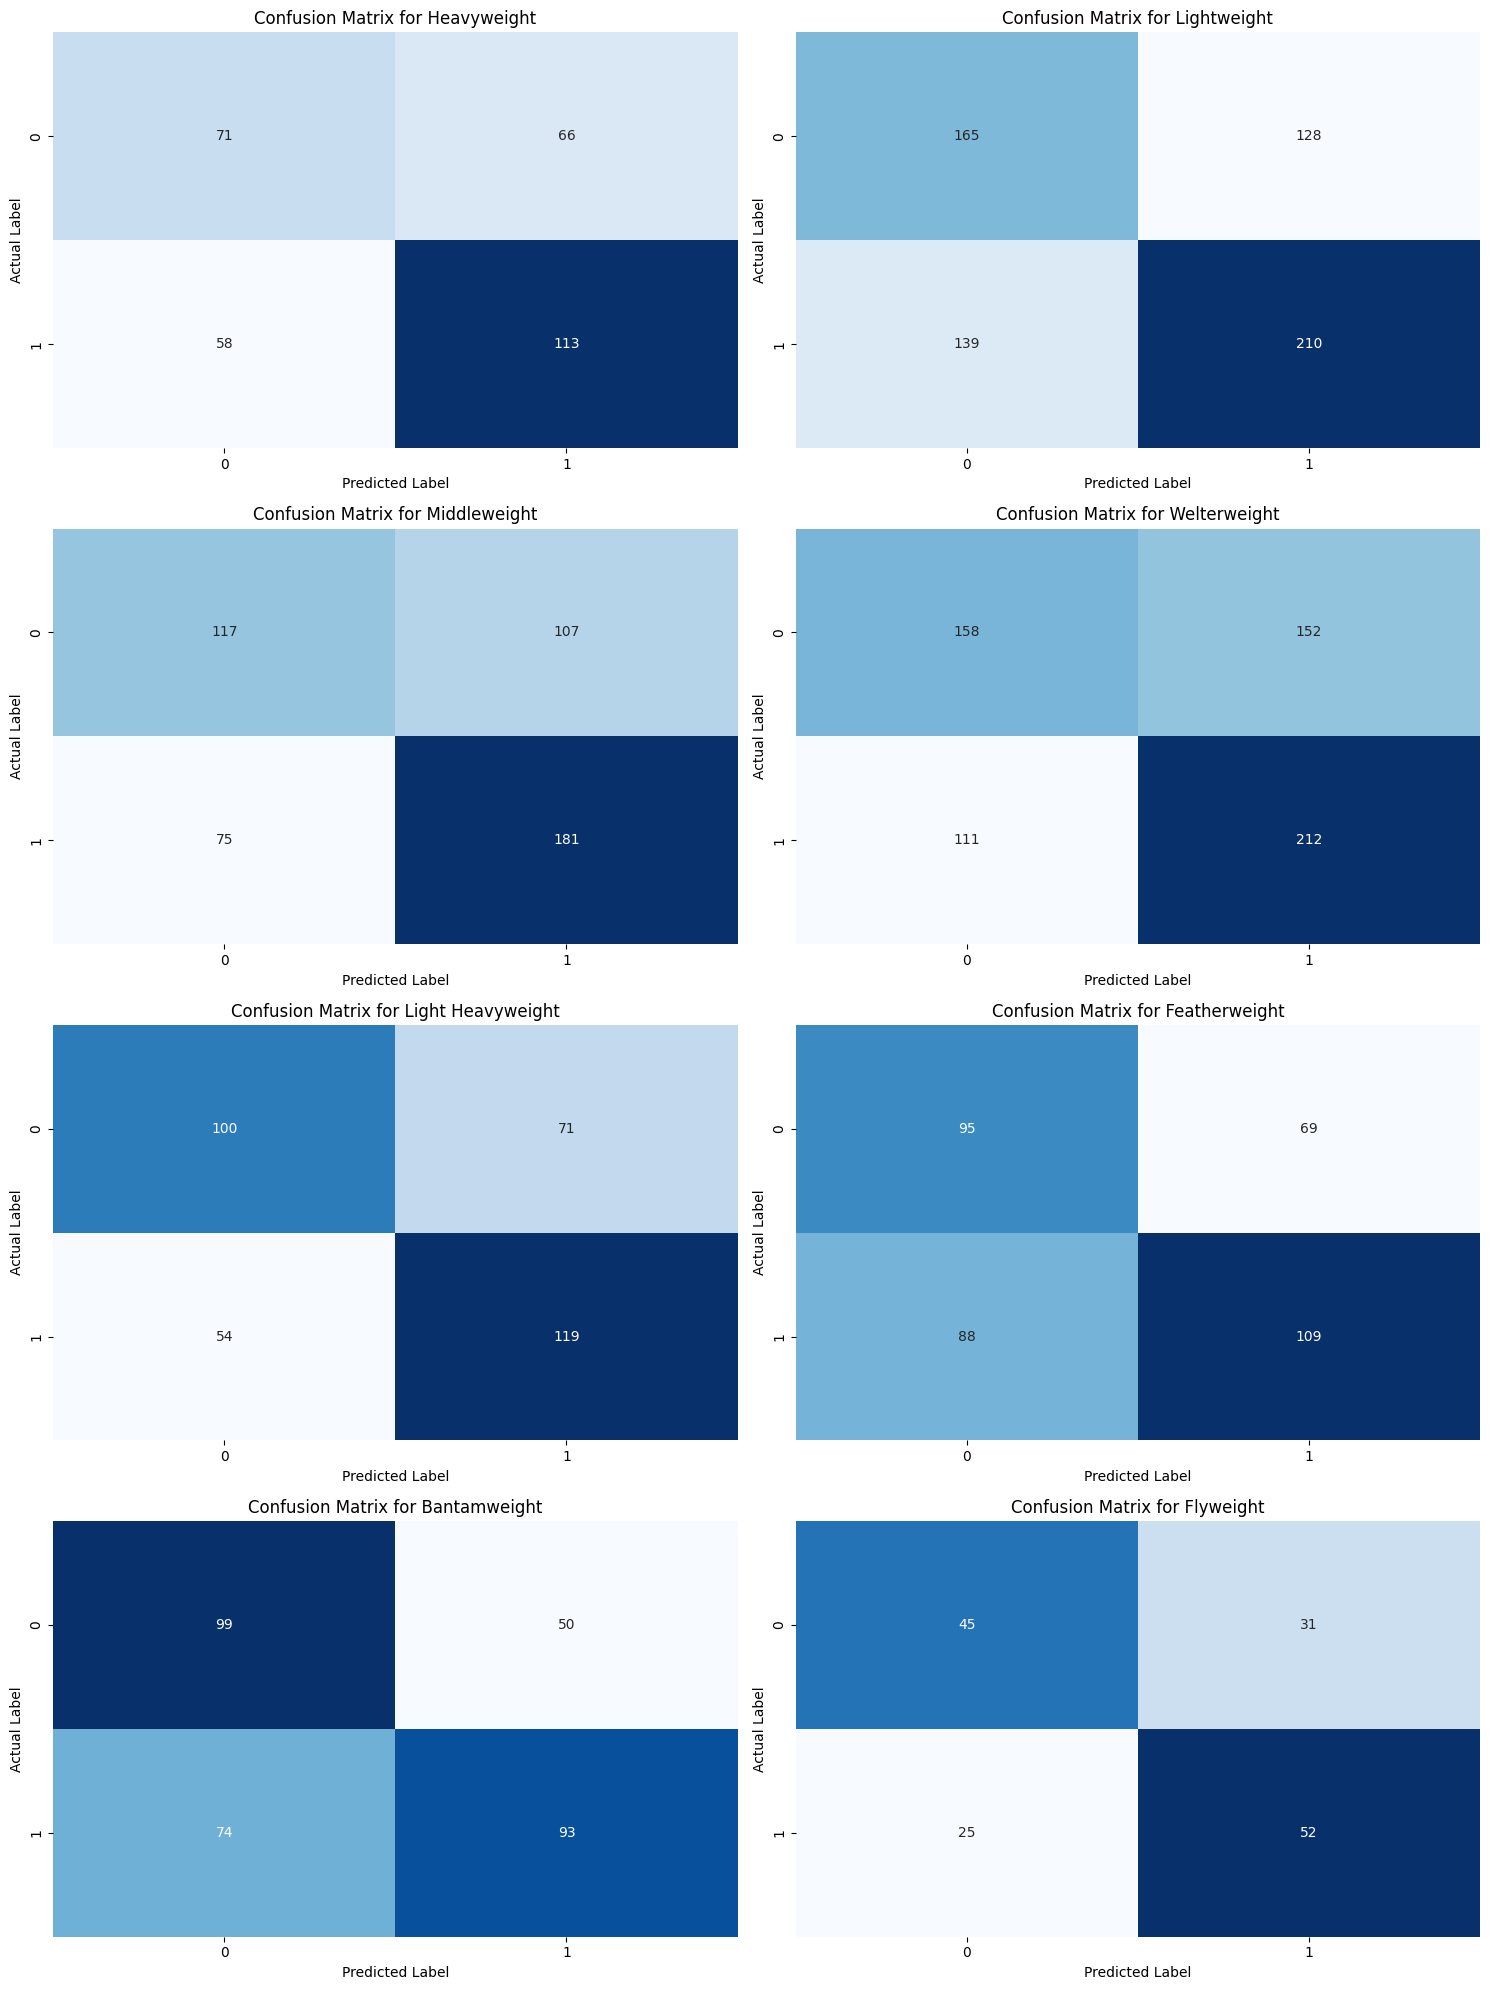

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

num_divisions = len(trained_models)
cols = 2 
rows = (num_divisions + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
axes = axes.flatten()

for i, (division, model) in enumerate(trained_models.items()):
    X_test = division_train_test_splits[division]['X_test']
    y_test = division_train_test_splits[division]['y_test']
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt="d", ax=axes[i], cmap='Blues', cbar=False)
    axes[i].set_title(f'Confusion Matrix for {division}')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('Actual Label')

if num_divisions % cols != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()


## ROC Curve
The Receiver Operating Characteristic (ROC) curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.
In our specific models, the curves provide insights into how well the model can discern the winning probabilities in different weight classes. It is particularly useful for evaluating the trade-offs between true positive rates and false positive rates, thus guiding us in fine-tuning our model's threshold to strike an optimal balance for predicting interesting fights.

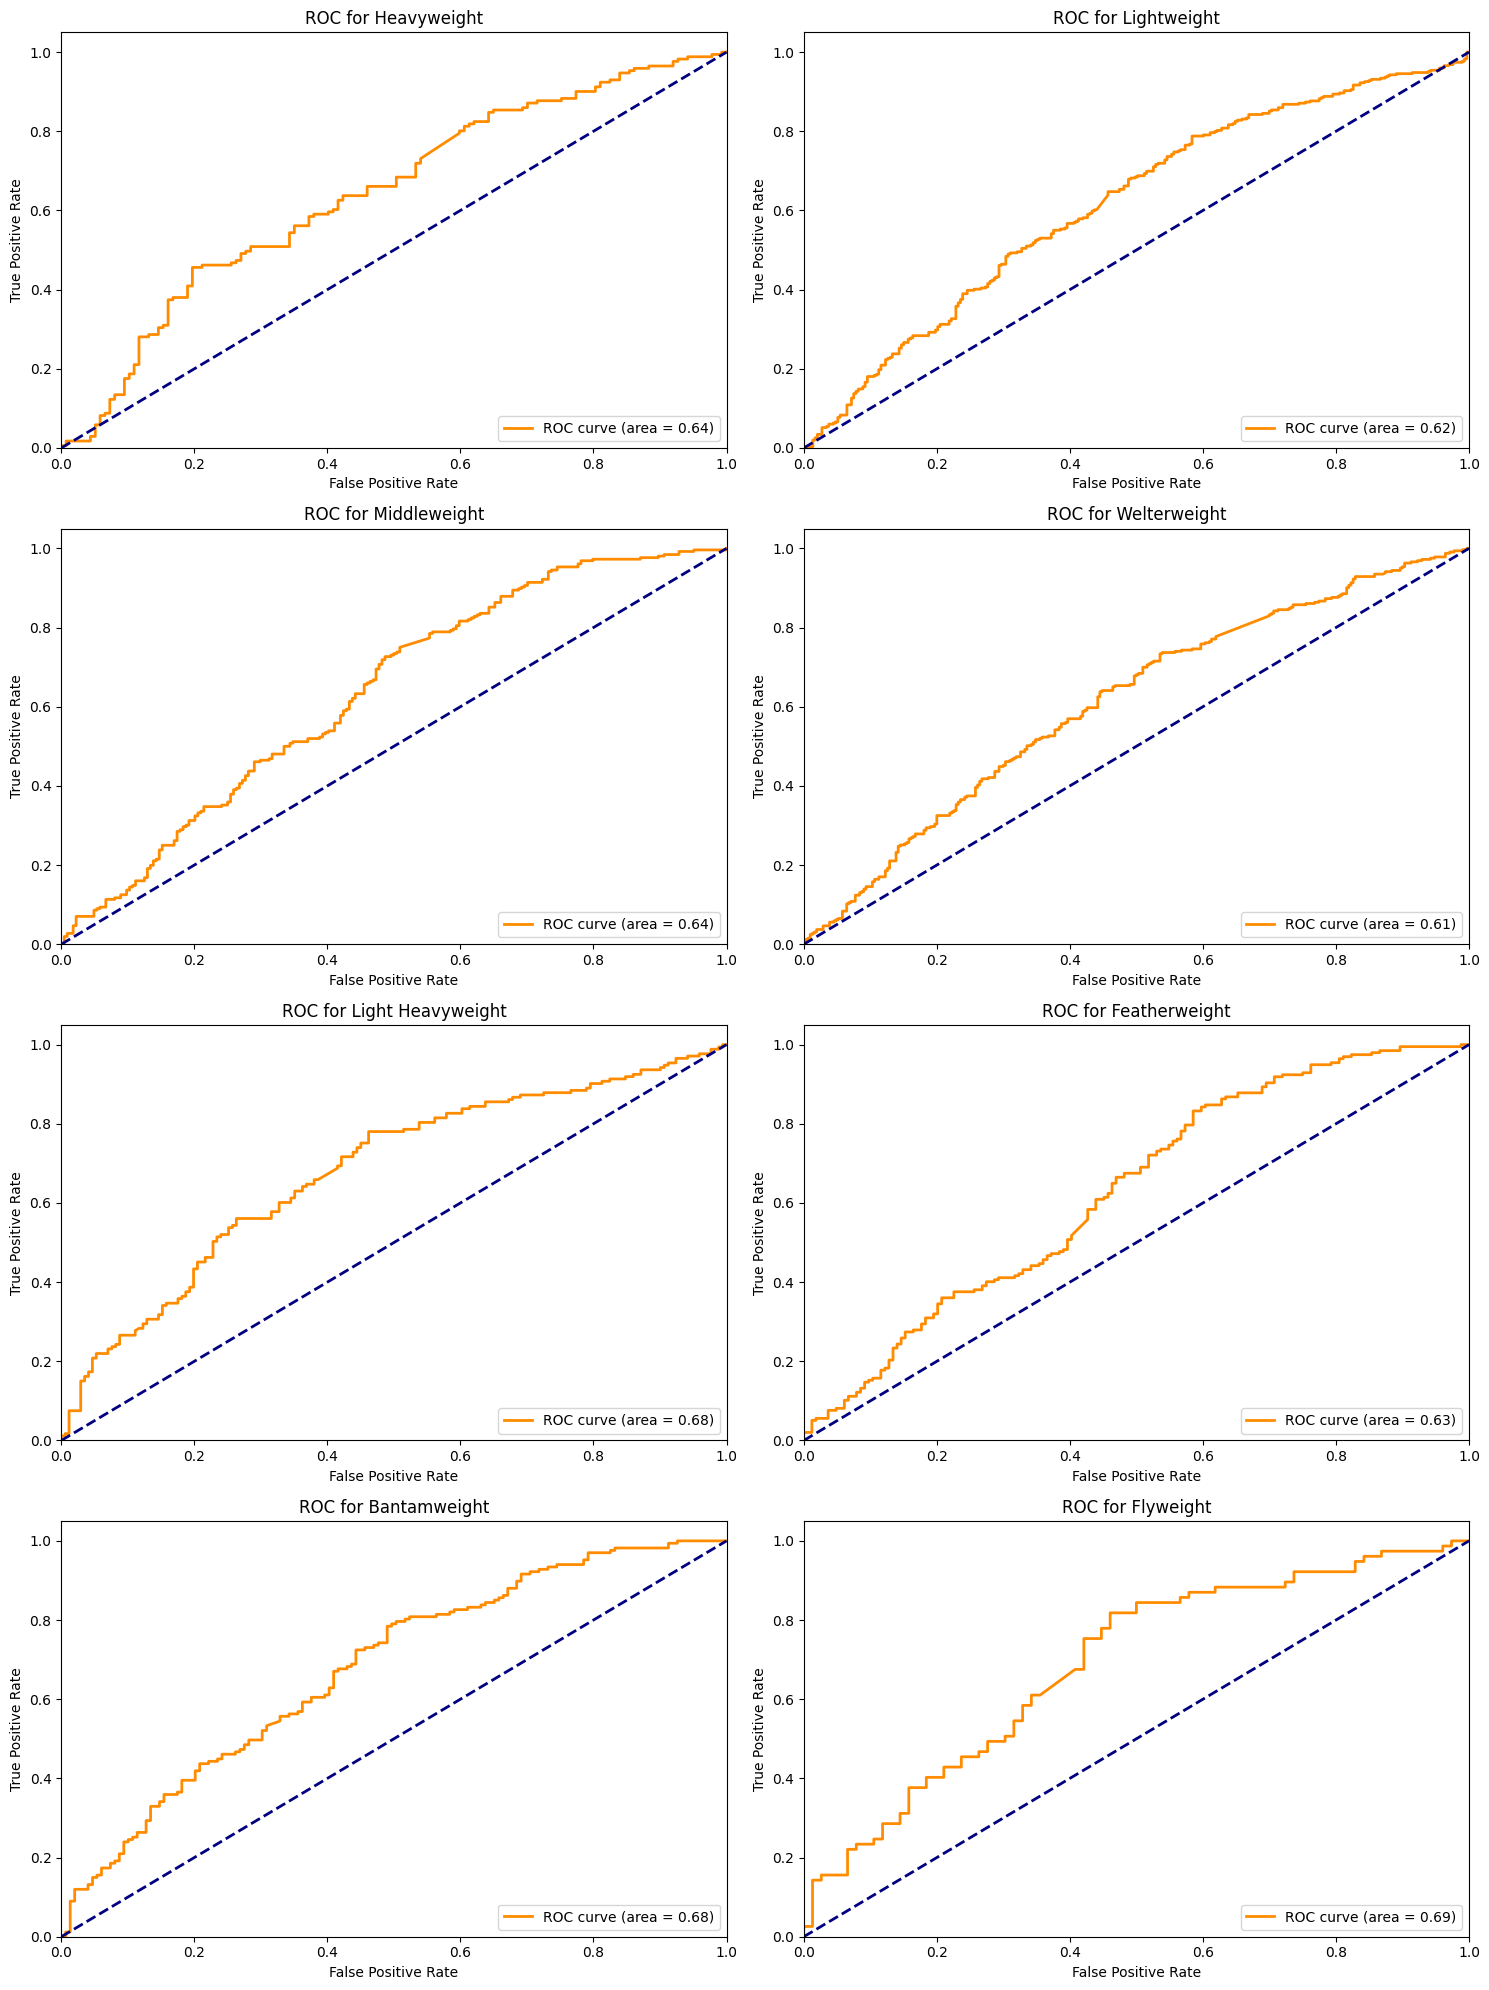

In [13]:
from sklearn.metrics import roc_curve, auc

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
axes = axes.flatten()

for i, (division, model) in enumerate(trained_models.items()):
    X_test = division_train_test_splits[division]['X_test']
    y_test = division_train_test_splits[division]['y_test']
    y_proba = model.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    axes[i].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    axes[i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[i].set_xlim([0.0, 1.0])
    axes[i].set_ylim([0.0, 1.05])
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_title(f'ROC for {division}')
    axes[i].legend(loc="lower right")

if num_divisions % cols != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

## Prediction Probability Distributions
The histograms display the frequency of the predicted probability of winning across fights in each weight class. The X-axis shows the model's confidence in predicting a win, ranging from 0 to 1. The Y-axis counts the number of predictions at each probability level. Peaks indicate common confidence levels the model assigns, and the spread reflects the model's certainty across the dataset. A wider spread suggests greater variability in fight outcomes, whereas a narrow peak suggests a trend towards more predictable results.

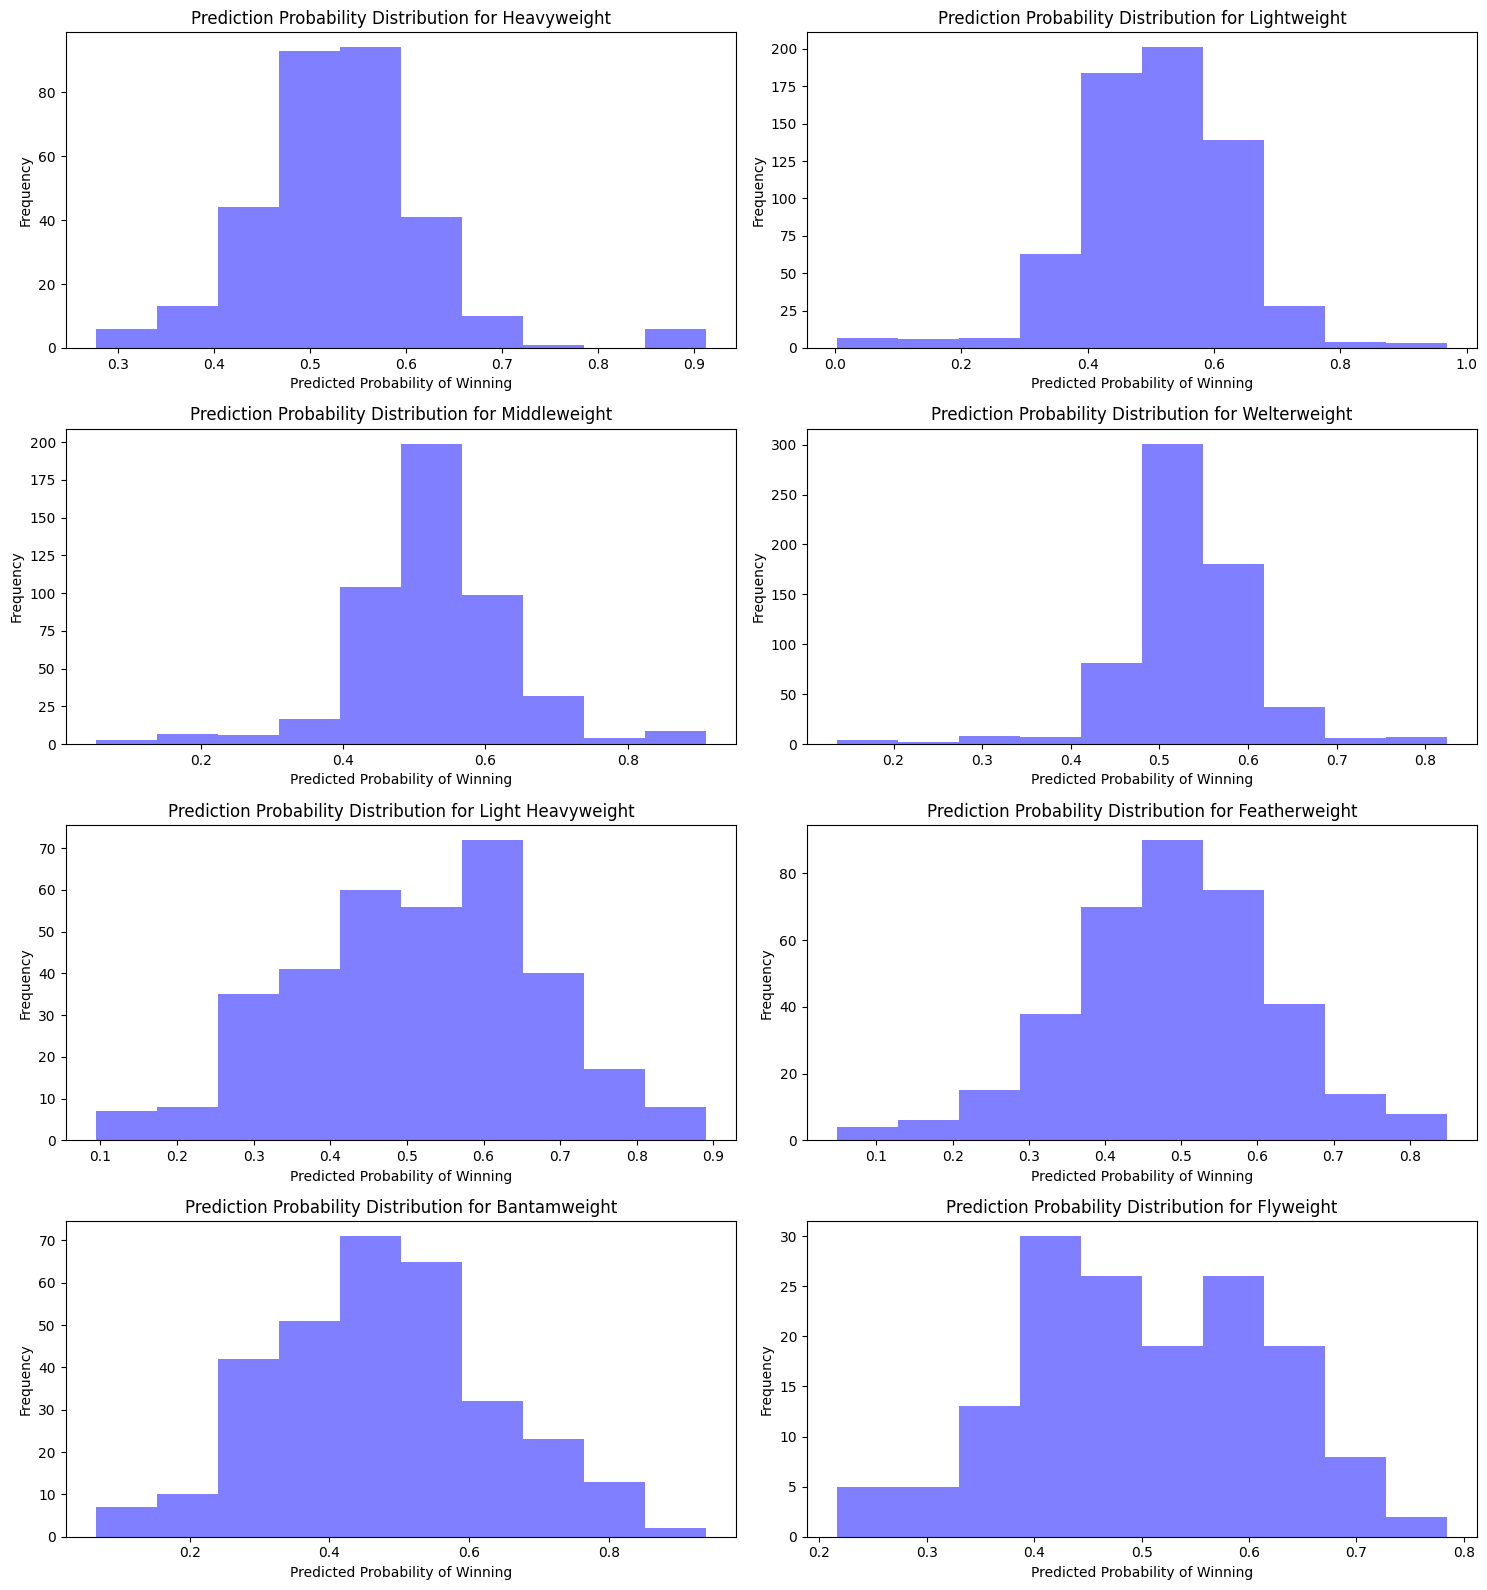

In [14]:
fig, axes = plt.subplots(rows, 2, figsize=(15, rows*4)) # Adjust the size as needed
axes = axes.flatten()

for i, (division, model) in enumerate(trained_models.items()):
    X_test = division_train_test_splits[division]['X_test']
    y_proba = model.predict_proba(X_test)[:, 1]
    
    axes[i].hist(y_proba, bins=10, alpha=0.5, color='blue')
    axes[i].set_title(f'Prediction Probability Distribution for {division}')
    axes[i].set_xlabel('Predicted Probability of Winning')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [15]:
from IPython.core.display_functions import clear_output
import numpy as np
import ipywidgets as widgets
from IPython.display import display

output = widgets.Output()

weight_class_dropdown = widgets.Dropdown(options=unique_divisions, description='Weight Class:')

def create_fighter_input_fields(description_suffix):
    return {
        'reach': widgets.FloatText(description=f'Reach [in] {description_suffix}:'),
        'height': widgets.FloatText(description=f'Height [in] {description_suffix}:'),
        'accuracy': widgets.FloatText(description=f'Accuracy % {description_suffix}:'),
        'age': widgets.IntText(description=f'Age {description_suffix}:')
    }


fighter1_inputs = create_fighter_input_fields("(F1)")
fighter2_inputs = create_fighter_input_fields("(F2)")

predict_button = widgets.Button(description='Predict Fight Outcome')

@output.capture(clear_output=True) 
def on_predict_button_clicked(b):
    with output:
        clear_output()
        fighter1_values = [fighter1_inputs['reach'].value, 
                           fighter1_inputs['height'].value, 
                           fighter1_inputs['accuracy'].value, 
                           fighter1_inputs['age'].value]
        
        fighter2_values = [fighter2_inputs['reach'].value, 
                           fighter2_inputs['height'].value, 
                           fighter2_inputs['accuracy'].value, 
                           fighter2_inputs['age'].value]
    
    selected_division = weight_class_dropdown.value
    
    fighter1_df = pd.DataFrame([[fighter1_values[0], fighter1_values[1], fighter1_values[2], fighter1_values[3]]], columns=columns_to_scale)
    fighter2_df = pd.DataFrame([[fighter2_values[0], fighter2_values[1], fighter2_values[2], fighter2_values[3]]], columns=columns_to_scale)
    
    f1_scaled = scaler.transform(fighter1_df)
    f2_scaled = scaler.transform(fighter2_df)
    
    interaction_model = trained_models[selected_division]
    
    f1_prediction = interaction_model.predict(f1_scaled)
    f1_prediction_proba = interaction_model.predict_proba(f1_scaled)
    f2_prediction = interaction_model.predict(f2_scaled)
    f2_prediction_proba = interaction_model.predict_proba(f2_scaled)
    
    f1_confidence = np.max(f1_prediction_proba, axis=1)[0]
    f2_confidence = np.max(f2_prediction_proba, axis=1)[0]
    
    confidence_diff = abs(f1_confidence - f2_confidence)
    
    interesting_threshold = 0.1 
    
    is_same = f1_prediction[0] == f2_prediction[0]
    is_interesting = confidence_diff < interesting_threshold
    
    print(f"Fighter 1 is predicted to {'Win' if f1_prediction[0] == 1 else 'Lose'} with a confidence of {f1_confidence:.2f}")
    print(f"Fighter 2 is predicted to {'Win' if f2_prediction[0] == 1 else 'Lose'} with a confidence of {f2_confidence:.2f}")
    print(f"Difference in confidence: {confidence_diff:.2f}")
    
    if is_interesting and is_same:
        print("This fight is expected to be competitive and interesting!")
    else:
        print("This fight may not be very competitive.")

predict_button.on_click(on_predict_button_clicked)

fighter1_widgets = widgets.VBox([fighter1_inputs[key] for key in fighter1_inputs])
fighter2_widgets = widgets.VBox([fighter2_inputs[key] for key in fighter2_inputs])
all_widgets = widgets.HBox([fighter1_widgets, fighter2_widgets, predict_button, weight_class_dropdown])

# Interactive Prediction Tool
## Instructions
- __Select a Weight Class:__ Use the dropdown to choose the weight class for the fight you are interested in.
- __Enter Fighter Statistics:__ Enter the statistics for each fighter, including reach, height, strike accuracy, and age.
- __Predict Fight Outcome:__ Click the `Predict Fight Outcome` button to see the model's prediction.
The model will output its prediction for each fighter along with the confidence level of the prediction.
If the model predicts different outcomes for the fighters or if the confidence levels are close, the fight is expected to be competitive and interesting.
#### Feel free to test different combinations of fighter statistics to explore the model's predictions and understand how different factors might influence the fight's outcome.

In [16]:
display(all_widgets, output)

Output()